In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
from flowprintOptimal.sekigo.modeling.neuralNetworks import TransformerGenerator,CNNNetwork2D,Predictor,CNNGenerator
from flowprintOptimal.sekigo.ood.GAN.trainers import GANTrainer,OODTrainer
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from flowprintOptimal.sekigo.utils.commons import augmentData
from flowprintOptimal.sekigo.modeling.trainers import NNClassificationTrainer
import torch.nn as nn
import torch.nn.functional as F
from flowprintOptimal.sekigo.modeling.loggers import Logger
from flowprintOptimal.sekigo.modeling.neuralNetworks import NeuralNetwork
import pandas as pd
torch.set_float32_matmul_precision('high')
from tqdm import tqdm

In [2]:
class MNISTDataset(Dataset):
    def __init__(self, root, label_to_index = None,train=True, ood=False, transform=None, download=True):
        self.train = train
        self.ood = ood
        self.label_to_index = label_to_index
        if self.ood:
            self.mnist_data = datasets.MNIST(root=root, train=train, transform=transform, download=download)
            self.filter_digits([6, 7, 8, 9])  # Filter out digits 6 to 9 for OOD dataset
            self.label_to_index = {6:0,7:1,8:2,9:3}
        else:
            self.mnist_data = datasets.MNIST(root=root, train=train, transform=transform, download=download)
            self.filter_digits([0,1,2,3,4,5])
            self.label_to_index = {0:0,1:1,2:2,3:3,4:4,5:5}
           

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, idx):
        data_point = self.mnist_data[idx]
        #torch.clamp(data_point[0],min= 0,max= 1)
        return dict(data = data_point[0], label = self.label_to_index[data_point[1]])

    def filter_digits(self, digits):
        filtered_indices = [i for i, (_, label) in enumerate(self.mnist_data) if label in digits]
        self.mnist_data = torch.utils.data.Subset(self.mnist_data, filtered_indices)

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

transform_non_train = transforms.Compose([
    transforms.ToTensor(),
])

# Create custom MNIST datasets
train_dataset = MNISTDataset(root='./data', train=True, transform=transform)
test_dataset = MNISTDataset(root='./data', train=False, ood=False, transform=transform_non_train)
ood_dataset = MNISTDataset(root='./data', train=True, ood=True, transform= transform_non_train)




In [3]:
seq_len = 49
random_dim = 8

discriminator = CNNNetwork2D(in_channels= 1,num_filters= 32,num_layers= 4,output_dim= 1)
generator = TransformerGenerator(output_dim= 16,random_dim= random_dim,embedding_dim= 64,num_heads= 4,num_layers= 5)
#generator = CNNGenerator(random_dim= random_dim)
classifier = CNNNetwork2D(in_channels= 1,num_filters= 16,num_layers= 3,output_dim= len(train_dataset.label_to_index) + 1)
logger = Logger(name= "GAN")
logger.default_step_size = 200

In [4]:
trainer = GANTrainer(generator= generator,discriminator= discriminator,logger= logger,is_img= True,random_dim= random_dim,seq_len= seq_len,compile= True,device= device)


GAN ---- 200 metric 0_discriminator_loss = -10.120755088254809
GAN ---- 200 metric 0_cost_wd = -14.676165439262986
GAN ---- 200 metric 0_gp_loss = 4.555410350770689
GAN ---- 200 metric generator_loss = 1.9082263497728855
GAN ---- 400 metric 0_discriminator_loss = -15.892380213737487
GAN ---- 400 metric 0_cost_wd = -24.503121614456177
GAN ---- 400 metric 0_gp_loss = 8.610741403102875
GAN ---- 400 metric generator_loss = 10.27898690223694
GAN ---- 600 metric 0_discriminator_loss = -28.079017877578735
GAN ---- 600 metric 0_cost_wd = -40.3094278717041
GAN ---- 600 metric 0_gp_loss = 12.23041000843048
GAN ---- 600 metric generator_loss = 21.759331045150756
GAN ---- 800 metric 0_discriminator_loss = -56.634099369049075
GAN ---- 800 metric 0_cost_wd = -77.54233100891113
GAN ---- 800 metric 0_gp_loss = 20.908231601715087
GAN ---- 800 metric generator_loss = 33.9255825138092
GAN ---- 1000 metric 0_discriminator_loss = -90.00973173141479
GAN ---- 1000 metric 0_cost_wd = -127.28218856811523
GAN -

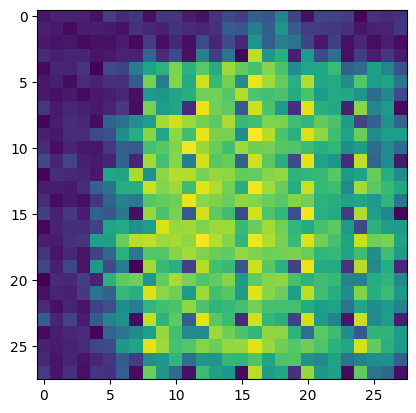

GAN ---- 1600 metric 0_discriminator_loss = -347.4691126251221
GAN ---- 1600 metric 0_cost_wd = -422.80424865722654
GAN ---- 1600 metric 0_gp_loss = 75.3351358795166
GAN ---- 1600 metric generator_loss = 119.04874908447266


In [5]:
trainer.train(train_dataset= train_dataset,batch_size= 128,n_critic= 1,gp_weight= 1,lr_discriminator= .00001,lr_generator= .00001,epochs= 50)

In [4]:
#trainer = GANTrainer(generator= generator,discriminator= discriminator,logger= logger,device= device)
trainer = OODTrainer(classifier= classifier,generator=generator,random_dim = random_dim,seq_len = seq_len,is_img= True,compile= True,
                     discriminator= discriminator,logger= logger,device= device,n= 1,classifier_only= False)

In [ ]:
trainer.train(train_dataset= train_dataset,batch_size= 128,n_critic= 3,epochs= 500,ood_dataset=ood_dataset,test_dataset=test_dataset,
              gp_weight= 1,lr_discriminator= .0001, lr_generator= .0001,lr_classifier= .0001)

In [16]:
generator = trainer.generator

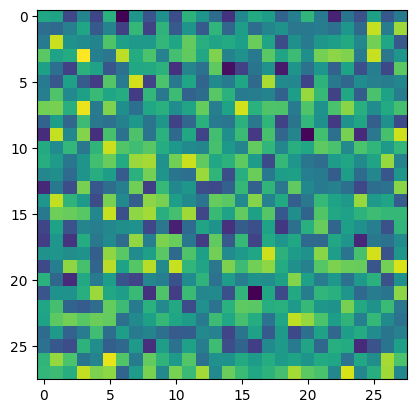

In [22]:
with torch.no_grad():
    z = trainer.generateRandomZ(1)
    out = generator(z)
    out = trainer.processgeneratorOutput(out)
    plot_out = out.cpu().numpy()[0][0]
    plt.imshow(plot_out)

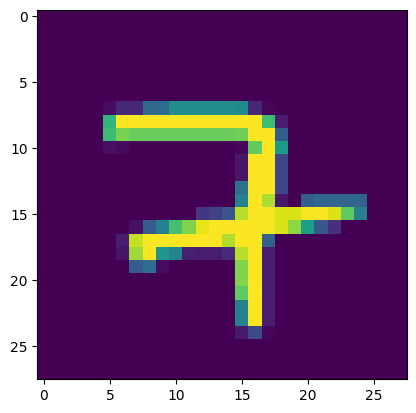

In [67]:
plt.imshow(ood_dataset[12]["data"][0])

In [50]:
train_dataset[0]["label"]

5

In [48]:
trainer.classifier(ood_dataset[0]["data"].unsqueeze(0).to(device))

tensor([[-4.9353, -4.2637, -4.3665, -4.3557,  0.1273, -5.9474, -1.1202]],
       device='cuda:0', grad_fn=<AddmmBackward0>)